# Lista 07 - Comparando Classificadores

# Exercício 01:

Analise o desempenho do kNN e de uma Regressão Logística Regularizada para **pelo menos um** dos conjuntos de dados abaixo:

* [Avaliação de carros](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
* [Avaliação de vinhos](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
* [Resultados de partidas do jogo Dota](http://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results) (desafiador!)

Para a questão, faça as seguintes tarefas:

* Realize treino, validação e teste
* Compare as métricas no teste
* Reporte a precisão, revocação, F1 e a matriz de confusão

Como já estamos no fim da matéria, você pode agora fazer uso da biblioteca scikit-learn. Afinal, no dia a dia, não implementamos tudo do zero. Abaixo temos os imports que vocês precisam. Leiam a API da biblioteca para saber como fazer uso da mesma.

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier

# Um fator importante é que o SKLearn não cria conjuntos de validação para você. Você tem algumas abordagens,
# uma é realizar um novo split no treino. Outra é fazer uso de classificadores com CV no fim.
# Tipo LogisticRegressionCV (ver na API). Por fim, você pode fazer uso da classe GridSearchCV.
# Leia a documentação da mesma.
from sklearn.model_selection import train_test_split

### Car Data

Escolhi a base de dados de avaliação de carros

In [3]:
#Primeiramente, ler os dados
import pandas as pd
df = pd.read_csv("data.csv")
df.head()


,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
#adicionando nomes para colunas para facilitar a indexacao dos dados
df.columns = ["buying","maint","doors","persons","lug_boot","safety","class"]
#Como a ultima coluna nao apresenta features (acho que eh lixo), a iremos remover
df["ID"] = df.index
df.head()


,buying,maint,doors,persons,lug_boot,safety,class,ID
0,vhigh,vhigh,2,2,small,med,unacc,0
1,vhigh,vhigh,2,2,small,high,unacc,1
2,vhigh,vhigh,2,2,med,low,unacc,2
3,vhigh,vhigh,2,2,med,med,unacc,3
4,vhigh,vhigh,2,2,med,high,unacc,4


In [5]:
# Agora, iremos plotar graficos para representar as distribuicoes dos dados
import matplotlib.pyplot as plt
def plot_dist(data,label,title, threshold=None):
    data[label].unique()
    aux = data[[label,'ID']]
    aux = aux.groupby([label]).count()
    if(threshold):
        aux = aux[aux["ID"]>threshold]
    
    aux = aux.sort_values('ID')
    
    plt.title(title)
    plt.bar(aux.index,aux["ID"])
    plt.show()

    
for col in df.columns:
    if(col!="ID"):
        plot_dist(df,col,"Distribuição da Coluna "+str(col))


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Como é possivel observar, todas as features são categóricas. Além disso, temos 4 classes possíveis.
Agora, iremos alterar as features para representação one-hot

In [6]:
import numpy as np
FEATURES = ["buying","maint","doors","persons","lug_boot","safety"]
TARGET = ["class"]

tgt = df[TARGET]
df = df.drop(["class","ID"],axis=1)
df = pd.get_dummies(df, columns=FEATURES).values
tgt = tgt.values
print(tgt)

[['unacc']
 ['unacc']
 ['unacc']
 ...
 ['unacc']
 ['good']
 ['vgood']]


## K-NN

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(df, tgt, test_size=0.2, random_state=23)

fold = 0
melhores = []
for nn in range(1,11): 
    best = (0, 0)
    accuracy=0
    for treino, validacao in skf.split(X_train, y_train):
        X_tt = X_train[treino]
        y_tt = y_train[treino]
        X_v = X_train[validacao]
        y_v = y_train[validacao]
        y_tt = pd.get_dummies(pd.DataFrame(y_tt)).values
        y_v = pd.get_dummies(pd.DataFrame(y_v)).values

        model = KNeighborsClassifier(n_neighbors=nn)
        model.fit(X_tt, y_tt) 
        y_pv = model.predict(X_v) 

        accuracy += accuracy_score(y_v, y_pv)
    accuracy/=splits
    if accuracy > best[0]:
        best = (accuracy, nn)

    melhores.append(best[1])
    fold += 1
    print('N-{}, acc = {}'.format(fold, best[0]))


N-1, acc = 0.7675103046384526
N-2, acc = 0.6205691009405834
N-3, acc = 0.8312638128747162
N-4, acc = 0.7495335272625618
N-5, acc = 0.846457774564719
N-6, acc = 0.7943832130154849
N-7, acc = 0.8566372259336615
N-8, acc = 0.8023067954283419
N-9, acc = 0.8552063772851511
N-10, acc = 0.80591946246698


Como podemos observar, o modelo com maior acurácia foi o que gerado utilizando K = 7.
Dessa forma, iremos gerar um novo modelo com K=7 para reportar as métricas desejadas

### Métricas
Utilizando o melhor modelo

In [8]:
from sklearn.metrics import classification_report

model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

         acc       0.78      0.87      0.82        71
        good       0.57      0.40      0.47        10
       unacc       0.97      0.97      0.97       255
       vgood       1.00      0.40      0.57        10

   micro avg       0.92      0.92      0.92       346
   macro avg       0.83      0.66      0.71       346
weighted avg       0.92      0.92      0.91       346



/home/breno/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### Matriz de Confusão

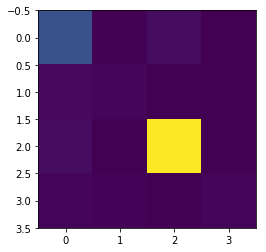

In [9]:
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))


## Regressão Logística

In [10]:
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(df, tgt, test_size=0.2, random_state=23)

best = (0, 0)
accuracy=0
#usaremos esse dicionario para categorizar as classes entre 0 e 3
#faremos isso para poder utilizar o modelo do sklearn, ja que ele
# nao aceita Y multi dimensional
dct = {'acc':1,'good':2,'unacc':3,'vgood':4}
for treino, validacao in skf.split(X_train, y_train):
    X_tt = X_train[treino]
    y_tt = y_train[treino]
    X_v = X_train[validacao]
    y_v = y_train[validacao]
    y_v = pd.DataFrame(y_v,columns=["data"])
    y_v = y_v.replace({"data": dct})
    y_tt = pd.DataFrame(y_tt,columns=['data'])
    y_tt = y_tt.replace({"data":dct})
    y_tt = y_tt.values
    y_v = y_v.values

    model = LogisticRegression( solver='lbfgs', multi_class='multinomial')
    model.fit(X_tt,np.ravel(y_tt,order='C')) 
    y_pv = model.predict(X_v) 

    accuracy += accuracy_score(np.ravel(y_v,order='C'), y_pv)

accuracy/=splits
if accuracy > best[0]:
    best = (accuracy, nn)

melhores.append(best[1])

print('Acuracia = {}'.format(best[0]))

Acuracia = 0.9029492671514516


### Métricas
Utilizando o melhor modelo

In [11]:
y_test = pd.DataFrame(y_test,columns=['data'])
y_test = y_test.replace({"data":dct})
y_test = y_test.values
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.78      0.89      0.83        71
           2       0.60      0.60      0.60        10
           3       0.97      0.95      0.96       255
           4       1.00      0.60      0.75        10

   micro avg       0.92      0.92      0.92       346
   macro avg       0.84      0.76      0.78       346
weighted avg       0.92      0.92      0.92       346



### Matriz de Confusão

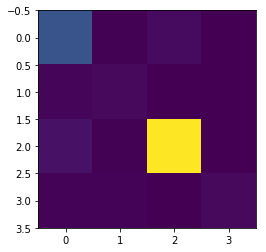

In [12]:
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))

Explique e discuta sobre os resultados encontrados no campo abaixo.

Ao fazer uso de treino/teste/validação, conseguimos tunar os modelos ao máximo, obtendo bons resultados de acurácia. A matriz de confusão gerada para os dois classificadores são bem semelhantes, demonstrando comportamento similar quanto à previsões corretas para as mesmas classes. Além disso, as classificações encontram-se bem distribúidas na diagonal principal, indicando que os modelos gerados são de boa qualidade. Por último, vale também ressaltar que o melhor modelo de K-NN não teve acurácia superior à regressão logística, sendo estas 0.86 e 0.89, respectivamente.